In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 

import pandas as pd
import numpy as np

import duckdb
import altair as alt
import wbgapi as wb

import json
import xmltodict
import xml.etree.ElementTree as ET

from zipfile import ZipFile
from io import BytesIO
from urllib.request import urlopen
from urllib.parse import urlencode
from mpl_toolkits.basemap import Basemap

# Data Ingestion from Open Data APIs and Data Manipulation using Pandas and DuckDB

Today's lecture will discuss two critical aspects of data science - data ingestion and data manipulation. First, we will examine how to acquire data from various open data APIs using the popular pandas library. Following that, we will explore strategies for merging, splitting, filtering, and transforming data using pandas and DuckDB, a high-performance analytical data management system. We will also demonstrate how to perform SQL queries on pandas DataFrames using DuckDB. 

## Data Ingestion from Open Data APIs using Pandas

[APIs (Application Programming Interfaces)](https://en.wikipedia.org/wiki/API) provide a robust way to access data from different sources, such as websites, databases, or other applications. They act as intermediaries allowing two applications to talk to each other and exchange data in a structured manner.

Pandas, we have seen in the last lecture, is a powerful Python library for data manipulation and analysis. It offers data structures and functions needed to work with structured data seamlessly.

For our first example, I am going to use [the US Department of Transportation](https://data.bts.gov/) to pull the data directly from their API. Please do check the site and play around with different data examples. They are very instructive. The particular dataset I am going to use is [Border Crossings by Mode, Border, and State](https://data.bts.gov/Research-and-Statistics/Border-Crossings-by-Mode-Border-and-State/erjk-mneb). The data format for this particular dataset is [Comma Separated Values (CSV)](https://en.wikipedia.org/wiki/Comma-separated_values). Pandas library has a specific function to ingest data in CSV format.

In [2]:
data = pd.read_csv('https://data.transportation.gov/api/views/keg4-3bc2/rows.csv?accessType=DOWNLOAD')
data

,Port Name,State,Port Code,Border,Date,Measure,Value,Latitude,Longitude,Point
0,Detroit,Michigan,3801,US-Canada Border,Aug 2023,Trains,128,42.332,-83.048,POINT (-83.047924 42.331685)
1,Alcan,Alaska,3104,US-Canada Border,Jul 2023,Bus Passengers,696,62.615,-141.001,POINT (-141.001444 62.614961)
2,Calais,Maine,115,US-Canada Border,Jul 2023,Buses,16,45.189,-67.275,POINT (-67.275381 45.188548)
3,Noonan,North Dakota,3420,US-Canada Border,Jul 2023,Trucks,142,48.999,-103.004,POINT (-103.004361 48.999333)
4,Warroad,Minnesota,3423,US-Canada Border,May 2023,Buses,41,48.999,-95.377,POINT (-95.376555 48.999)
...,...,...,...,...,...,...,...,...,...,...
385766,Richford,Vermont,203,US-Canada Border,Feb 1996,Buses,0,45.012,-72.589,POINT (-72.588559 45.01174)
385767,Vanceboro,Maine,105,US-Canada Border,Jul 1997,Truck Containers Empty,263,45.569,-67.429,POINT (-67.428541 45.568761)
385768,Fort Fairfield,Maine,107,US-Canada Border,May 1996,Rail Containers Loaded,0,46.765,-67.789,POINT (-67.789471 46.765323)
385769,Pembina,North Dakota,3401,US-Canada Border,Jan 1996,Truck Containers Empty,1663,49.000,-97.237,POINT (-97.237036 49.000453)


As usual, the `Date` column contains the dates as strings which need to be converted into Date and Time.

In [3]:
data['Date'] = pd.to_datetime(data['Date'],format="%b %Y")
data

,Port Name,State,Port Code,Border,Date,Measure,Value,Latitude,Longitude,Point
0,Detroit,Michigan,3801,US-Canada Border,2023-08-01,Trains,128,42.332,-83.048,POINT (-83.047924 42.331685)
1,Alcan,Alaska,3104,US-Canada Border,2023-07-01,Bus Passengers,696,62.615,-141.001,POINT (-141.001444 62.614961)
2,Calais,Maine,115,US-Canada Border,2023-07-01,Buses,16,45.189,-67.275,POINT (-67.275381 45.188548)
3,Noonan,North Dakota,3420,US-Canada Border,2023-07-01,Trucks,142,48.999,-103.004,POINT (-103.004361 48.999333)
4,Warroad,Minnesota,3423,US-Canada Border,2023-05-01,Buses,41,48.999,-95.377,POINT (-95.376555 48.999)
...,...,...,...,...,...,...,...,...,...,...
385766,Richford,Vermont,203,US-Canada Border,1996-02-01,Buses,0,45.012,-72.589,POINT (-72.588559 45.01174)
385767,Vanceboro,Maine,105,US-Canada Border,1997-07-01,Truck Containers Empty,263,45.569,-67.429,POINT (-67.428541 45.568761)
385768,Fort Fairfield,Maine,107,US-Canada Border,1996-05-01,Rail Containers Loaded,0,46.765,-67.789,POINT (-67.789471 46.765323)
385769,Pembina,North Dakota,3401,US-Canada Border,1996-01-01,Truck Containers Empty,1663,49.000,-97.237,POINT (-97.237036 49.000453)


## DuckDB, SQL and Pandas

I am going to use [duckdb](https://duckdb.org/docs/archive/0.9.1/) which allows us to query pandas data frames in memory without dumping the data into a database. This is especially useful since SQL is the industry standard for querying data collections. SQL stands for [Structured Query Language](https://en.wikipedia.org/wiki/SQL), and it is the most standard way to merge, split, filter, and aggregate data collections. You may find a detailed description of the language in [this wikibook](https://en.wikibooks.org/wiki/Structured_Query_Language). I also put a *cheat-sheet* in "Class Files" folders on Ninova.

Let us continue with our example.  I need to create the interface between DuckDB and our data frame `data`:

In [4]:
con = duckdb.connect('data')
con

`SELECT` is the main keyword that does the querying.

In [21]:
con.query("""
  select State, Measure, sum(Value) as "Number of Passengers" from data
         where Date >= '2022-01-01' 
               and Date <= '2022-12-31'
         group by State, Measure
         order by "Number of Passengers" desc;
""")

┌──────────────┬─────────────────────────────┬──────────────────────┐
│    State     │           Measure           │ Number of Passengers │
│   varchar    │           varchar           │        int128        │
├──────────────┼─────────────────────────────┼──────────────────────┤
│ Texas        │ Personal Vehicle Passengers │             60224826 │
│ California   │ Personal Vehicle Passengers │             49210767 │
│ Texas        │ Personal Vehicles           │             32590240 │
│ California   │ Personal Vehicles           │             30246680 │
│ Arizona      │ Personal Vehicle Passengers │             16978897 │
│ California   │ Pedestrians                 │             16104055 │
│ Texas        │ Pedestrians                 │             14034169 │
│ New York     │ Personal Vehicle Passengers │              9439951 │
│ Arizona      │ Personal Vehicles           │              9404110 │
│ Washington   │ Personal Vehicle Passengers │              6089730 │
│     ·        │   ·

Let me also show you how to do the same thing within pandas without appealing to duckdb:

In [18]:
data.query("Date>='2022-01-01' and Date<='2022-12-31'")[['Value','State','Measure']].groupby(['State','Measure']).sum().sort_values(by='Value', ascending=False)
    

Value
State      Measure                              
Texas      Personal Vehicle Passengers  60224826
California Personal Vehicle Passengers  49210767
Texas      Personal Vehicles            32590240
California Personal Vehicles            30246680
Arizona    Personal Vehicle Passengers  16978897
...                                          ...
Montana    Buses                             168
           Train Passengers                  118
Vermont    Pedestrians                        94
Idaho      Buses                              11
Alaska     Train Passengers                    2

[160 rows x 1 columns]

In [24]:
res = con.query("""
  select strftime('%Y-%b',Date) as Date, sum(Value) as 'Number of Crossings' 
         from data
         where Measure = 'Trucks' and Border = 'US-Mexico Border'
         group by Date 
         order by Date;
""")
res

┌──────────┬─────────────────────┐
│   Date   │ Number of Crossings │
│ varchar  │       int128        │
├──────────┼─────────────────────┤
│ 1996-Apr │              241608 │
│ 1996-Aug │              275565 │
│ 1996-Dec │              281887 │
│ 1996-Feb │              258334 │
│ 1996-Jan │              255176 │
│ 1996-Jul │              269974 │
│ 1996-Jun │              263040 │
│ 1996-Mar │              269872 │
│ 1996-May │              279286 │
│ 1996-Nov │              292096 │
│    ·     │                 ·   │
│    ·     │                 ·   │
│    ·     │                 ·   │
│ 2022-Oct │              623060 │
│ 2022-Sep │              604571 │
│ 2023-Apr │              577035 │
│ 2023-Aug │              639570 │
│ 2023-Feb │              582010 │
│ 2023-Jan │              599549 │
│ 2023-Jul │              596400 │
│ 2023-Jun │              646375 │
│ 2023-Mar │              672503 │
│ 2023-May │              665779 │
├──────────┴─────────────────────┤
│ 332 rows (20 shown

The result is in the DuckDB format which you may use as is, or convert it to pandas dataframe:

In [26]:
res = res.to_df()
res

,Date,Number of Crossings
0,1996-Apr,241608.0
1,1996-Aug,275565.0
2,1996-Dec,281887.0
3,1996-Feb,258334.0
4,1996-Jan,255176.0
...,...,...
327,2023-Jan,599549.0
328,2023-Jul,596400.0
329,2023-Jun,646375.0
330,2023-Mar,672503.0


Now, let us plot the results:

<Axes: >

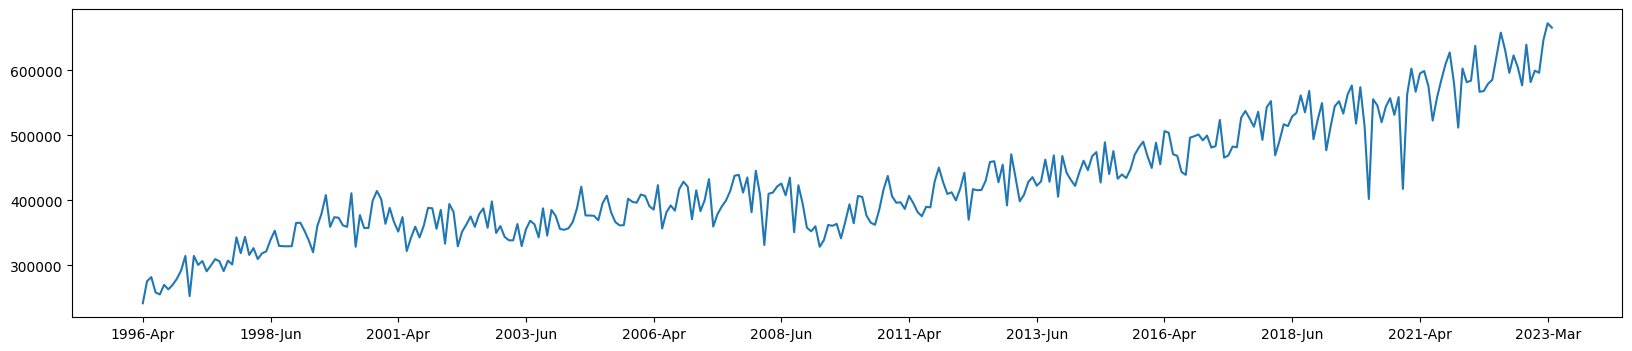

In [27]:
pos = range(0,res.shape[0],30)
plt.xticks(ticks = pos, labels = res['Date'][pos])
res['Number of Crossings'].plot(figsize=(20,4))

Let us find the number of border crossings in Personal Vehicles per State during the year 2023.

In [28]:
con.query("""
  select State, sum(Value) as 'Number of Crossings' from data 
      where Date > '2022-12-31' 
            and Measure like 'Personal Vehicles'
      group by State
      order by "Number of Crossings" ASC;
""").to_df()

,State,Number of Crossings
0,Alaska,89280.0
1,Idaho,105683.0
2,North Dakota,295964.0
3,Montana,298585.0
4,Minnesota,448584.0
5,Vermont,642752.0
6,New Mexico,718391.0
7,Maine,952455.0
8,Michigan,3192604.0
9,Washington,3297898.0


In [30]:
res = data[['Value','State']][data['Measure']=='Trucks'].groupby('State').sum().sort_values(by='Value')
res

,Value
State,
Alaska,279592
Idaho,1654196
Minnesota,2258203
New Mexico,2274435
Montana,4717872
Vermont,7006461
North Dakota,10079116
Arizona,10319309
Maine,10475932


<BarContainer object of 14 artists>

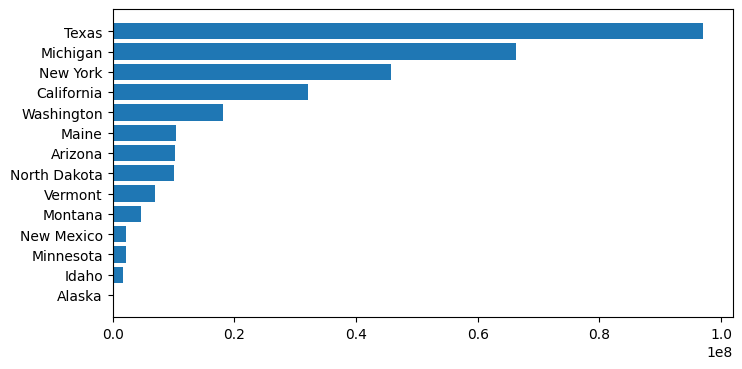

In [31]:
plt.figure(figsize=(8,4))
plt.barh(y = res.index, width = res['Value'])

## Second Example

For this example, I am going to use [Istanbul Belediyesi Data Service](https://data.ibb.gov.tr/) API. The particular dataset I am going to pull is [Raylı Sistemler Hat Bazlı Sefer Sayıları](https://data.ibb.gov.tr/dataset/321aa12d-a388-4c61-b915-522730b8230a/resource/f676e493-8995-4e50-90b3-5381da92627f). The data comes in [Microsoft Excel](https://en.wikipedia.org/wiki/Microsoft_Excel) format. As before, we are going to use pandas to ingest the data.

In [39]:
xls = pd.read_excel("https://data.ibb.gov.tr/dataset/321aa12d-a388-4c61-b915-522730b8230a/resource/f676e493-8995-4e50-90b3-5381da92627f/download/rayl-sistemler-hat-bazl-sefer-saylar.xlsx")
xls

,Tarih,M1,M2,M3,M4,M5,M6,M7,M9,T1,T4,T5,F1,T3,TF1,TF2
0,2017-01-01,21575,22479,16561,11762,NaN,7502,NaN,NaN,21497,12353,NaN,11950,NaN,NaN,NaN
1,2017-02-01,19488,20288,15012,10644,NaN,6776,NaN,NaN,19536,11188,NaN,10808,NaN,NaN,NaN
2,2017-03-01,21582,22846,16689,11820,NaN,7650,NaN,NaN,21714,12439,NaN,11978,NaN,NaN,NaN
3,2017-04-01,20870,21680,15967,11413,NaN,7260,NaN,NaN,20755,11949,NaN,11560,NaN,NaN,NaN
4,2017-05-01,21568,22588,16575,11784,NaN,7518,NaN,NaN,21612,12361,NaN,11604,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2021-12-01,21765,19130,8378,11692,11229.0,7590,9857.0,7275.0,23579,12753,7978.0,8432,2335.0,2524.0,5165.0
60,2022-01-01,21648,18938,8138,11448,11074.0,7605,10149.0,7203.0,22624,12333,7690.0,8438,2291.0,2171.0,4862.0
61,2022-02-01,19599,17164,7572,10508,10111.0,6854,9061.0,7544.0,21223,11459,7036.0,9296,2070.0,2057.0,4677.0
62,2022-03-01,21677,19084,8378,11755,11099.0,7580,10077.0,7273.0,23516,12734,7779.0,10136,2350.0,2944.0,5522.0


In [40]:
xls['Tarih'] = pd.to_datetime(xls['Tarih'])
xls.fillna(0, inplace=True)
xls.index = xls['Tarih']
xls

,Tarih,M1,M2,M3,M4,M5,M6,M7,M9,T1,T4,T5,F1,T3,TF1,TF2
Tarih,,,,,,,,,,,,,,,,
2017-01-01,2017-01-01,21575,22479,16561,11762,0.0,7502,0.0,0.0,21497,12353,0.0,11950,0.0,0.0,0.0
2017-02-01,2017-02-01,19488,20288,15012,10644,0.0,6776,0.0,0.0,19536,11188,0.0,10808,0.0,0.0,0.0
2017-03-01,2017-03-01,21582,22846,16689,11820,0.0,7650,0.0,0.0,21714,12439,0.0,11978,0.0,0.0,0.0
2017-04-01,2017-04-01,20870,21680,15967,11413,0.0,7260,0.0,0.0,20755,11949,0.0,11560,0.0,0.0,0.0
2017-05-01,2017-05-01,21568,22588,16575,11784,0.0,7518,0.0,0.0,21612,12361,0.0,11604,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,2021-12-01,21765,19130,8378,11692,11229.0,7590,9857.0,7275.0,23579,12753,7978.0,8432,2335.0,2524.0,5165.0
2022-01-01,2022-01-01,21648,18938,8138,11448,11074.0,7605,10149.0,7203.0,22624,12333,7690.0,8438,2291.0,2171.0,4862.0
2022-02-01,2022-02-01,19599,17164,7572,10508,10111.0,6854,9061.0,7544.0,21223,11459,7036.0,9296,2070.0,2057.0,4677.0


In [41]:
con = duckdb.connect('xls')
res = con.query("""
    select strftime('%Y-%m-%d',Tarih) as Date, M1, M2, M4, M5, M7, T1 from xls
        order by Tarih;
""").to_df()
res

,Date,M1,M2,M4,M5,M7,T1
0,2017-01-01,21575,22479,11762,0.0,0.0,21497
1,2017-02-01,19488,20288,10644,0.0,0.0,19536
2,2017-03-01,21582,22846,11820,0.0,0.0,21714
3,2017-04-01,20870,21680,11413,0.0,0.0,20755
4,2017-05-01,21568,22588,11784,0.0,0.0,21612
...,...,...,...,...,...,...,...
59,2021-12-01,21765,19130,11692,11229.0,9857.0,23579
60,2022-01-01,21648,18938,11448,11074.0,10149.0,22624
61,2022-02-01,19599,17164,10508,10111.0,9061.0,21223
62,2022-03-01,21677,19084,11755,11099.0,10077.0,23516


<Axes: xlabel='Date'>

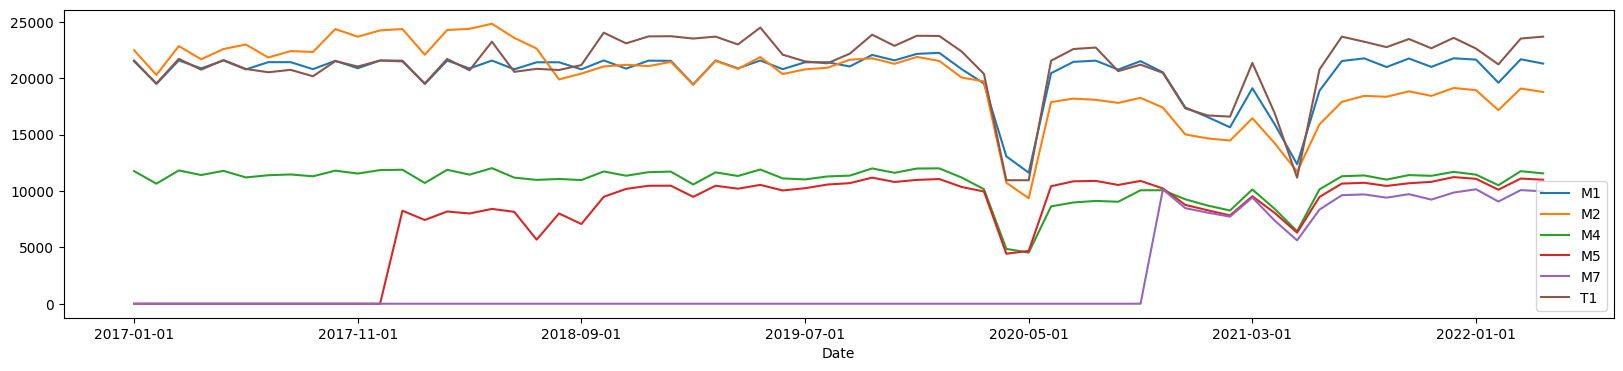

In [42]:
res.index = res['Date']
res.plot(figsize=(20,4))

In [43]:
tmp = con.query(f"""
    unpivot xls on {', '.join(xls.columns[1:])}
    order by Tarih;
""").to_df()
tmp

,Tarih,name,value
0,2017-01-01,M1,21575.0
1,2017-01-01,M2,22479.0
2,2017-01-01,M3,16561.0
3,2017-01-01,M4,11762.0
4,2017-01-01,M5,0.0
...,...,...,...
955,2022-04-01,T5,7691.0
956,2022-04-01,F1,9950.0
957,2022-04-01,T3,2225.0
958,2022-04-01,TF1,3014.0


In [44]:
def lineGraph(df,xName,yName,cName,ylim=[0,1]):
    nearest = alt.selection_point(
        nearest=True, on='mouseover',
        fields=[xName], empty=False
    )

    line = alt.Chart(df).mark_line(interpolate='basis').encode(
        x=xName,
        y=alt.Y(yName, scale=alt.Scale(domain=ylim)),
        color=cName
    )

    selectors = alt.Chart(df).mark_point().encode(
        x=xName,
        opacity=alt.value(0),
    ).add_params(nearest)

    points = line.mark_point().encode(
        opacity=alt.condition(
            nearest, 
            alt.value(1), 
            alt.value(0))
    )

    text = line.mark_text(
        align='left', dx=5, dy=5).encode(
            text=alt.condition(nearest, yName, alt.value(' '))
    )

    rules = alt.Chart(df).mark_rule(color='gray').encode(
        x=xName,
    ).transform_filter(nearest)

    return alt.layer(line, text, rules, points, selectors)
    return 

In [45]:
graph = lineGraph(tmp,'Tarih','value','name',[0,2.5e4])
graph.properties(
    width=1600, height=600
).interactive()

/home/kaygun/local/venv/lib/python3.11/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

## Third Example

For this example, I am going to use [World Bank Data Server](https://data.worldbank.org/). The service has its own python library called [wbgapi](https://pypi.org/project/world-bank-data/).

In [32]:
hci = pd.DataFrame(wb.data.fetch('HD.HCI.OVRL',economy=['ITA','TUR','GRC','CYP','BGR','ROU','RUS','IRN']))
hci.dropna(inplace=True)
hci

,value,series,economy,aggregate,time
2,0.593404,HD.HCI.OVRL,IRN,False,YR2020
4,0.592209,HD.HCI.OVRL,IRN,False,YR2018
5,0.591000,HD.HCI.OVRL,IRN,False,YR2017
12,0.564322,HD.HCI.OVRL,IRN,False,YR2010
65,0.681420,HD.HCI.OVRL,RUS,False,YR2020
67,0.728950,HD.HCI.OVRL,RUS,False,YR2018
68,0.729000,HD.HCI.OVRL,RUS,False,YR2017
75,0.600549,HD.HCI.OVRL,RUS,False,YR2010
128,0.584188,HD.HCI.OVRL,ROU,False,YR2020
130,0.594410,HD.HCI.OVRL,ROU,False,YR2018


In [33]:
hci['time'] = pd.to_datetime(hci['time'],format='YR%Y')
hci = hci.sort_values(by='time')
hci

,value,series,economy,aggregate,time
201,0.636619,HD.HCI.OVRL,BGR,False,2010-01-01
390,0.627476,HD.HCI.OVRL,TUR,False,2010-01-01
327,0.714860,HD.HCI.OVRL,GRC,False,2010-01-01
264,0.686362,HD.HCI.OVRL,CYP,False,2010-01-01
138,0.599882,HD.HCI.OVRL,ROU,False,2010-01-01
75,0.600549,HD.HCI.OVRL,RUS,False,2010-01-01
453,0.750266,HD.HCI.OVRL,ITA,False,2010-01-01
12,0.564322,HD.HCI.OVRL,IRN,False,2010-01-01
131,0.601000,HD.HCI.OVRL,ROU,False,2017-01-01
383,0.626000,HD.HCI.OVRL,TUR,False,2017-01-01


In [46]:
graph = lineGraph(hci,'time','value','economy',[0.54,0.8])
graph.properties(
    width=1600, height=600
).interactive()

/home/kaygun/local/venv/lib/python3.11/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [47]:
tmp = hci[['value','time','economy']].pivot_table(index='time',columns='economy',aggfunc='sum')
tmp

value                                                    \
economy          BGR       CYP       GRC       IRN       ITA       ROU   
time                                                                     
2010-01-01  0.636619  0.686362  0.714860  0.564322  0.750266  0.599882   
2017-01-01  0.676000  0.751000  0.681000  0.591000  0.769000  0.601000   
2018-01-01  0.670277  0.754617  0.694806  0.592209  0.752880  0.594410   
2020-01-01  0.613898  0.755520  0.690006  0.593404  0.727820  0.584188   

                                
economy          RUS       TUR  
time                            
2010-01-01  0.600549  0.627476  
2017-01-01  0.729000  0.626000  
2018-01-01  0.728950  0.625310  
2020-01-01  0.681420  0.649262

In [48]:
con = duckdb.connect('hci')
con.query("""
   pivot hci on economy 
   using sum(value)
   order by time;
""").to_df()

,series,aggregate,time,BGR,CYP,GRC,IRN,ITA,ROU,RUS,TUR
0,HD.HCI.OVRL,False,2010-01-01,0.636619,0.686362,0.714860,0.564322,0.750266,0.599882,0.600549,0.627476
1,HD.HCI.OVRL,False,2017-01-01,0.676000,0.751000,0.681000,0.591000,0.769000,0.601000,0.729000,0.626000
2,HD.HCI.OVRL,False,2018-01-01,0.670277,0.754617,0.694806,0.592209,0.752880,0.594410,0.728950,0.625310
3,HD.HCI.OVRL,False,2020-01-01,0.613898,0.755520,0.690006,0.593404,0.727820,0.584188,0.681420,0.649262


<Axes: xlabel='time'>

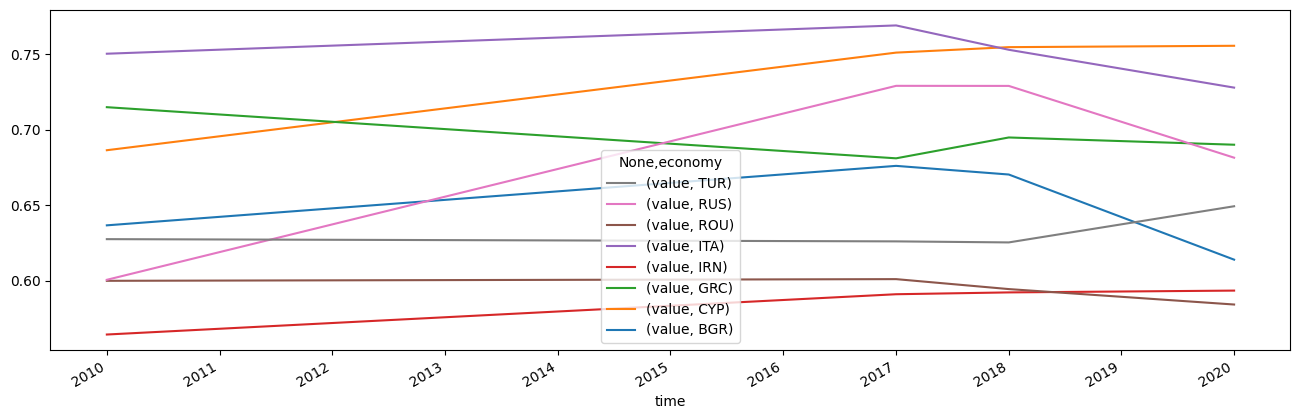

In [49]:
tmp.plot(figsize=(16,5),legend='reverse',kind='line')

## A Crash Course on Data File Formats

As data scientists, we are often required to ingest and process data from various sources, which come in a variety of file formats. Today, we'll discuss four commonly used formats, namely CSV, JSON, XML, and YAML. I'll give you a brief overview, along with simple examples, and we will discuss how these formats can be visualized differently.

### CSV (Comma Separated Values)

CSV is a plain text file format where each row of data is represented as a line, with data fields separated by commas. A CSV file typically contains the data in a tabular, or rectangular matrix, format. The first line may contain the column names or headers. This simplistic format makes CSV files easy to read and write, and they're widely used for exchanging data between applications.

Simple CSV example:
```
Name,Age,Occupation
Alice,30,Engineer
Bob,25,Scientist
Charlie,35,Artist
```
In this example, the first row contains the headers, while each following row represents a person's information in three fields (Name, Age, Occupation). Visualization of the data is simple: we can think of it as a rectangular table or spreadsheet.

We have seen CSV examples above

### JSON (JavaScript Object Notation)

JSON is a text-based format designed to be human-readable. It is derived from JavaScript, but can be used independently and as a data interchange format across many programming languages. JSON uses key-value pairs to store data and is hierarchical in nature, meaning that the data can be visually represented as a tree structure.

Simple JSON example:
```
[
  {
    "Name": "Alice",
    "Age": 30,
    "Occupation": "Engineer"
  },
  {
    "Name": "Bob",
    "Age": 25,
    "Occupation": "Scientist"
  },
  {
    "Name": "Charlie",
    "Age": 35,
    "Occupation": "Artist"
  }
]
```
In this example, each person's information is stored as an object containing key-value pairs, with the entire dataset represented as a JSON array. Unlike CSV, JSON data is visualized as a tree structure instead of a rectangular table.

Here is a real-life example:

In [19]:
with urlopen("https://api.ons.gov.uk/timeseries/JP9Z/dataset/UNEM/data") as url:
    json_data = json.load(url)

json_data

{'description': {'cdid': 'JP9Z',
  'contact': {'email': 'bob.watson@ons.gov.uk',
   'name': 'Bob Watson',
   'telephone': '+44 1633 455070'},
  'datasetId': 'UNEM',
  'datasetUri': '/employmentandlabourmarket/peoplenotinwork/unemployment/datasets/claimantcountandvacanciesdataset',
  'date': '2023 JUL',
  'monthLabelStyle': 'three month average',
  'nextRelease': '17 October 2023',
  'number': '870',
  'preUnit': '',
  'releaseDate': '2023-09-11T23:00:00.000Z',
  'sampleSize': '0',
  'source': '',
  'title': 'UK Job Vacancies (thousands) - Total Services',
  'unit': ''},
 'months': [{'date': '2001 MAY',
   'label': '2001 APR-JUN',
   'month': 'May',
   'quarter': '',
   'sourceDataset': 'UNEM',
   'updateDate': '2022-04-11T23:00:00.000Z',
   'value': '568',
   'year': '2001'},
  {'date': '2001 JUN',
   'label': '2001 MAY-JUL',
   'month': 'June',
   'quarter': '',
   'sourceDataset': 'UNEM',
   'updateDate': '2022-04-11T23:00:00.000Z',
   'value': '564',
   'year': '2001'},
  {'date': '

In [213]:
json_data['months'][1]

{'date': '2001 JUN',
 'label': '2001 MAY-JUL',
 'month': 'June',
 'quarter': '',
 'sourceDataset': 'UNEM',
 'updateDate': '2022-04-11T23:00:00.000Z',
 'value': '564',
 'year': '2001'}

In [214]:
df = pd.DataFrame(pd.json_normalize(json_data["months"]))

df['date'] = pd.to_datetime(df['date'],format='%Y %b')
df['value'] = pd.to_numeric(df['value'])
df.index = df.date
df = df.sort_index()
df

,date,label,month,quarter,sourceDataset,updateDate,value,year
date,,,,,,,,
2001-05-01,2001-05-01,2001 APR-JUN,May,,UNEM,2022-04-11T23:00:00.000Z,568,2001
2001-06-01,2001-06-01,2001 MAY-JUL,June,,UNEM,2022-04-11T23:00:00.000Z,564,2001
2001-07-01,2001-07-01,2001 JUN-AUG,July,,UNEM,2023-04-17T23:00:00.000Z,554,2001
2001-08-01,2001-08-01,2001 JUL-SEP,August,,UNEM,2022-04-11T23:00:00.000Z,554,2001
2001-09-01,2001-09-01,2001 AUG-OCT,September,,UNEM,2022-04-11T23:00:00.000Z,536,2001
...,...,...,...,...,...,...,...,...
2023-03-01,2023-03-01,2023 FEB-APR,March,,UNEM,2023-08-14T23:00:00.000Z,958,2023
2023-04-01,2023-04-01,2023 MAR-MAY,April,,UNEM,2023-09-11T23:00:00.000Z,928,2023
2023-05-01,2023-05-01,2023 APR-JUN,May,,UNEM,2023-09-11T23:00:00.000Z,909,2023


<Axes: title={'center': 'UK Job Vacancies (thousands)'}, xlabel='date'>

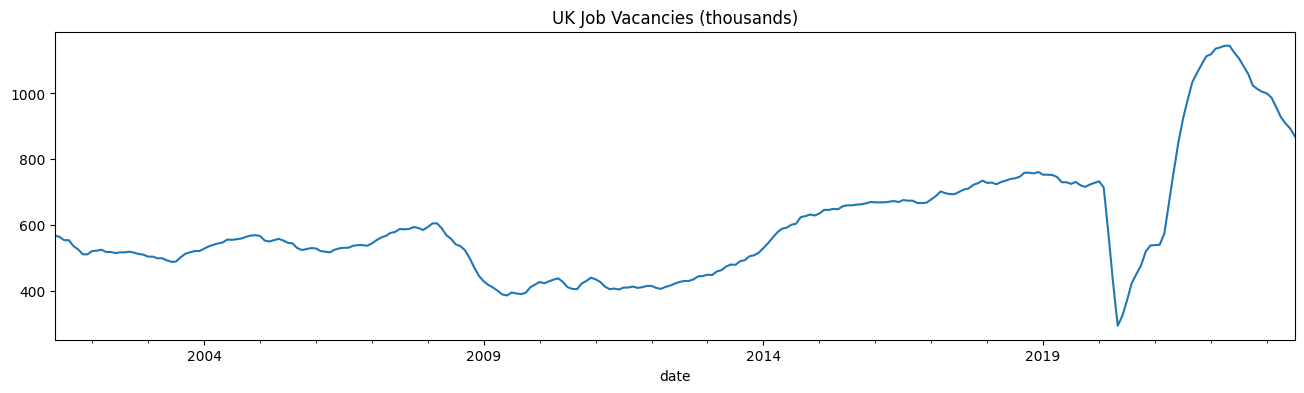

In [215]:
plt.title('UK Job Vacancies (thousands)')
df['value'].plot(figsize=(16,4))

## XML (eXtensible Markup Language)
XML is a markup language, similar to HTML, that uses tags to describe the structure of data. XML is hierarchical, and the data contained within an XML document can be visually represented as a tree structure. XML is versatile and can be used to represent a wide variety of data structures.

Simple XML example:
```xml
<people>
  <person>
    <Name>Alice</Name>
    <Age>30</Age>
    <Occupation>Engineer</Occupation>
  </person>
  <person>
    <Name>Bob</Name>
    <Age>25</Age>
    <Occupation>Scientist</Occupation>
  </person>
  <person>
    <Name>Charlie</Name>
    <Age>35</Age>
    <Occupation>Artist</Occupation>
  </person>
</people>
```
In this example, each person's information is contained within a <person> tag, and the entire dataset is nested under the <people> tag. Like JSON, XML data is visualized as a tree structure.

There are many variations of XML. Most famous and widely used variation of XML is [Hypertext Markup Language (HTML)](https://en.wikipedia.org/wiki/HTML). XML requires its own lecture (which I am not going to do!). The safest method to deal with XML via python is to convert it into a dictionary (or a hash-map) via [xmltodict](https://github.com/martinblech/xmltodict) library.

Here is a real-life example:

In [22]:
with urlopen("http://www.ecb.europa.eu/stats/eurofxref/eurofxref-daily.xml") as url:
    raw = url.read()

In [23]:
tree = ET.fromstring(raw)
tree

<Element '{http://www.gesmes.org/xml/2002-08-01}Envelope' at 0x7f2c5b5ebfb0>

In [24]:
ET.indent(tree)
print(ET.tostring(tree,encoding='unicode'))

<ns0:Envelope xmlns:ns0="http://www.gesmes.org/xml/2002-08-01" xmlns:ns1="http://www.ecb.int/vocabulary/2002-08-01/eurofxref">
  <ns0:subject>Reference rates</ns0:subject>
  <ns0:Sender>
    <ns0:name>European Central Bank</ns0:name>
  </ns0:Sender>
  <ns1:Cube>
    <ns1:Cube time="2023-10-13">
      <ns1:Cube currency="USD" rate="1.0524" />
      <ns1:Cube currency="JPY" rate="157.44" />
      <ns1:Cube currency="BGN" rate="1.9558" />
      <ns1:Cube currency="CZK" rate="24.670" />
      <ns1:Cube currency="DKK" rate="7.4582" />
      <ns1:Cube currency="GBP" rate="0.86415" />
      <ns1:Cube currency="HUF" rate="387.73" />
      <ns1:Cube currency="PLN" rate="4.5350" />
      <ns1:Cube currency="RON" rate="4.9648" />
      <ns1:Cube currency="SEK" rate="11.5500" />
      <ns1:Cube currency="CHF" rate="0.9546" />
      <ns1:Cube currency="ISK" rate="146.50" />
      <ns1:Cube currency="NOK" rate="11.5160" />
      <ns1:Cube currency="TRY" rate="29.2576" />
      <ns1:Cube currency="AU

Let us convert this into a dictionary first:

In [25]:
dict = xmltodict.parse(raw)
dict

{'gesmes:Envelope': {'@xmlns:gesmes': 'http://www.gesmes.org/xml/2002-08-01',
  '@xmlns': 'http://www.ecb.int/vocabulary/2002-08-01/eurofxref',
  'gesmes:subject': 'Reference rates',
  'gesmes:Sender': {'gesmes:name': 'European Central Bank'},
  'Cube': {'Cube': {'@time': '2023-10-13',
    'Cube': [{'@currency': 'USD', '@rate': '1.0524'},
     {'@currency': 'JPY', '@rate': '157.44'},
     {'@currency': 'BGN', '@rate': '1.9558'},
     {'@currency': 'CZK', '@rate': '24.670'},
     {'@currency': 'DKK', '@rate': '7.4582'},
     {'@currency': 'GBP', '@rate': '0.86415'},
     {'@currency': 'HUF', '@rate': '387.73'},
     {'@currency': 'PLN', '@rate': '4.5350'},
     {'@currency': 'RON', '@rate': '4.9648'},
     {'@currency': 'SEK', '@rate': '11.5500'},
     {'@currency': 'CHF', '@rate': '0.9546'},
     {'@currency': 'ISK', '@rate': '146.50'},
     {'@currency': 'NOK', '@rate': '11.5160'},
     {'@currency': 'TRY', '@rate': '29.2576'},
     {'@currency': 'AUD', '@rate': '1.6662'},
     {'@cur

In [26]:
pd.DataFrame.from_dict(dict['gesmes:Envelope']['Cube']['Cube']['Cube'])

,@currency,@rate
0,USD,1.0524
1,JPY,157.44
2,BGN,1.9558
3,CZK,24.670
4,DKK,7.4582
5,GBP,0.86415
6,HUF,387.73
7,PLN,4.5350
8,RON,4.9648
9,SEK,11.5500


## YAML (YAML Ain't Markup Language)

YAML is a human-readable data serialization format. It uses indentation and simple punctuation marks to represent the hierarchical structure of data. YAML is easy to read and write, and is often used for configuration files, data exchange between languages, and data storage.

Simple YAML example:
```yaml
- Name: Alice
  Age: 30
  Occupation: Engineer
- Name: Bob
  Age: 25
  Occupation: Scientist
- Name: Charlie
  Age: 35
  Occupation: Artist
```
In this example, each item is represented by a hyphen and indentation. Like JSON and XML, YAML data is visualized as a tree structure.

YAML Usually is used for configuration files.

# Data Sources and Data APIs

Large part of doing data science is working with data: cleaning, understanding, filtering, and tranforming it. But in order to do that we need data. Unless you collect your own data, you will need to find interesting data sets that you can understand and ask questions about. Today, we are going to look at possible data sources and their uses.

An [application programming interface (API)](https://en.wikipedia.org/wiki/API) is a data connection between two pieces of software. For our purposes, it is a connection between a data consumer (you) and data provider.  Its primary function is **not** to provide data for human consumption, rather it is for exchanging data between two computer programs. In short, you'll use an API to fetch the data not to look at it in its raw form.


## Toy Datasets for Teaching and Experimenting

Sometimes, one needs data to learn a topic, make small experiments before embarking on *real* large datasets. For that there is one specific place: [UCI's data repository](https://archive.ics.uci.edu/ml/datasets.php).

Here are a couple of examples:

### Mammographic Masses

[Data](https://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/) is about mammography test results on breast tumors.  It is of columnar format (CSV) and contains 7 columns:

1. BI-RADS assessment: 1 to 5 (ordinal, non-predictive!)
2. Age: patient's age in years (integer)
3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)

The remaining column indicate whether the tumor is benign (encoded as 0) or malignant (encoded as 1).

In [120]:
cancer = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data', header=None)    
cancer.columns = ['assessment','age','shape','margin','density','type']
cancer

,assessment,age,shape,margin,density,type
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1
...,...,...,...,...,...,...
956,4,47,2,1,3,0
957,4,56,4,5,3,1
958,4,64,4,5,3,0
959,5,66,4,5,3,1


In [121]:
cancer.describe()

,type
count,961.000000
mean,0.463059
std,0.498893
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


(array([ 95.,   0., 224.,   0.,   0., 400.,   0.,  31.,   0., 211.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

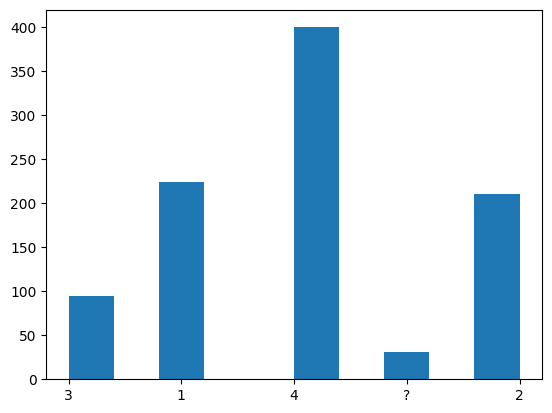

In [123]:
plt.hist(cancer['shape'])

In [140]:
tbl = pd.crosstab(cancer['shape'],cancer['margin'])
tbl

margin,1,2,3,4,5,?
shape,,,,,,
1,184,2,4,10,8,16
2,145,5,14,36,2,9
3,22,6,19,31,8,9
4,5,11,75,192,113,4
?,1,0,4,11,5,10


In [142]:
from scipy.stats import chi2_contingency

analysis = chi2_contingency(tbl)
analysis

Chi2ContingencyResult(statistic=659.5861991501424, pvalue=7.745804641347427e-127, dof=20, expected_freq=array([[ 83.21331946,   5.59417274,  27.03850156,  65.2653486 ,
         31.70031217,  11.18834547],
       [ 78.38397503,   5.26951093,  25.46930281,  61.47762747,
         29.86056191,  10.53902185],
       [ 35.29136316,   2.37252862,  11.46722164,  27.67950052,
         13.44432882,   4.74505723],
       [148.59521332,   9.98959417,  48.2830385 , 116.54526535,
         56.60770031,  19.97918835],
       [ 11.51612903,   0.77419355,   3.74193548,   9.03225806,
          4.38709677,   1.5483871 ]]))

In [146]:
pd.DataFrame(analysis.expected_freq).astype('int')

,0,1,2,3,4,5
0,83,5,27,65,31,11
1,78,5,25,61,29,10
2,35,2,11,27,13,4
3,148,9,48,116,56,19
4,11,0,3,9,4,1


### Bank Marketing Data Set

[The data](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) is about marketing campaigns of a Portuguese bank. The marketing campaigns were done via phone. Data again is of columnar format. It contains 21 columns:

1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4.  education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5.  default: has credit in default? (categorical: 'no','yes','unknown')
6.  housing: has housing loan? (categorical: 'no','yes','unknown')
7.  loan: has personal loan? (categorical: 'no','yes','unknown')
8.  contact: contact communication type (categorical: 'cellular','telephone')
9.  month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10.  day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11.  duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
12.  campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13.  pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14.  previous: number of contacts performed before this campaign and for this client (numeric)
15.  poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
16.  emp.var.rate: employment variation rate.  quarterly indicator (numeric)
17.  cons.price.idx: consumer price index.  monthly indicator (numeric)
18.  cons.conf.idx: consumer confidence index.  monthly indicator (numeric)
19.  euribor3m: euribor 3 month rate.  daily indicator (numeric)
20.  nr.employed: number of employees.  quarterly indicator (numeric)


The remaining column is indicates whether the customer bought the banking service that was advertised/marketed.

The file is in [ZIP format](https://en.wikipedia.org/wiki/ZIP_(file_format)) which need to be read in a different way:

In [28]:
with urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip') as url:
    zf = ZipFile(BytesIO(url.read()))
    bank = pd.read_csv(zf.open('bank.csv'),sep=';')
    
bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


## Data From Municipalities

We have used [data from Istanbul Municipality data service](https://data.ibb.gov.tr/). There are other municipalties that serves open data:

1. [Istanbul Municipality](https://data.ibb.gov.tr/)
2. [Izmir Municipality](https://acikveri.bizizmir.com/)
3. [Bursa Municipality](https://acikyesil.bursa.bel.tr/dataset/)
4. [Athens Open Data](http://geodata.gov.gr/en/dataset)
4. [Barcelona Municipality](https://opendata-ajuntament.barcelona.cat/)
5. [London Data Store](https://data.london.gov.uk/developers/)
6. [New York Open Data](https://opendata.cityofnewyork.us/)
7. [City of Montreal Open Data](https://donnees.montreal.ca/collections)
8. [City of Toronto Open Data](https://open.toronto.ca/)

Best way to explore is search "open data api" + your favorite city :) 

In [29]:
water = pd.read_excel('https://data.ibb.gov.tr/dataset/78ef6c0c-3fd0-45bd-812d-7232384a3b6d/resource/762b802e-c5f9-4175-a5c1-78b892d9764b/download/ibb_yags_verileri_2011-23.xlsx')
water

,Tarih,Ömerli,Darlik,Elmali,Terkos,B.çekmece,Sazlidere,Alibey,Kazandere,Pabuçdere
0,2011-01-01,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
1,2011-01-02,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
2,2011-01-03,0.00,0.00,0.00,0.42,1.37,0.87,0.2,2.26,1.89
3,2011-01-04,8.08,10.01,11.64,18.82,9.64,14.72,13.5,8.20,10.37
4,2011-01-05,2.78,8.48,7.09,3.42,0.83,4.31,4.3,1.44,1.60
...,...,...,...,...,...,...,...,...,...,...
4468,2023-03-27,2.65,2.20,5.41,9.20,1.71,2.50,4.0,4.30,2.80
4469,2023-03-28,9.66,12.00,25.87,3.20,18.89,16.25,20.3,7.10,5.40
4470,2023-03-29,20.01,21.80,37.92,11.40,16.92,16.25,14.9,1.60,1.20
4471,2023-03-30,3.21,1.60,3.71,1.60,2.08,1.75,2.6,0.00,0.00


In [154]:
water['Tarih'] = pd.to_datetime(water['Tarih'])
water.index = water['Tarih']
tmp = water[water['Tarih'] >= pd.to_datetime('2022-01-01')][water.columns[1:]]
tmp

,Ömerli,Darlik,Elmali,Terkos,B.çekmece,Sazlidere,Alibey,Kazandere,Pabuçdere
Tarih,,,,,,,,,
2022-01-01,0.00,0.00,0.00,0.0,0.00,0.00,0.5,0.00,0.00
2022-01-02,4.62,4.20,1.35,0.0,0.00,0.10,0.4,0.20,0.00
2022-01-03,1.80,0.93,3.62,0.0,0.00,0.00,0.0,0.86,0.43
2022-01-04,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00
2022-01-05,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...
2023-03-27,2.65,2.20,5.41,9.2,1.71,2.50,4.0,4.30,2.80
2023-03-28,9.66,12.00,25.87,3.2,18.89,16.25,20.3,7.10,5.40
2023-03-29,20.01,21.80,37.92,11.4,16.92,16.25,14.9,1.60,1.20


<Axes: xlabel='Tarih'>

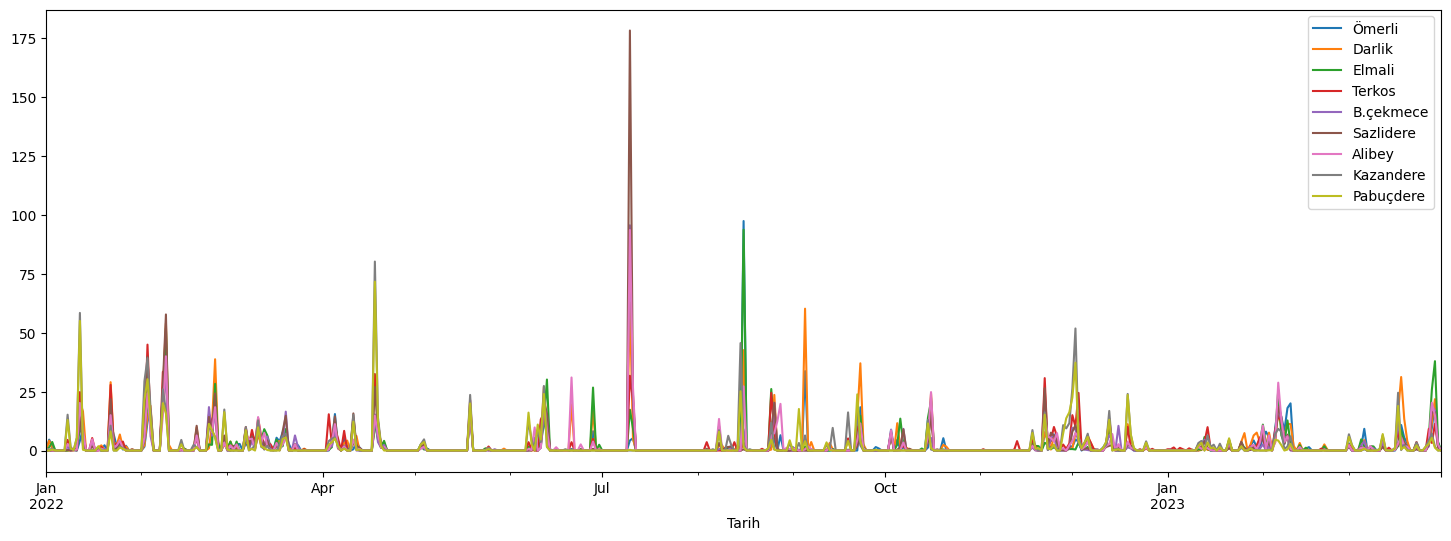

In [155]:
tmp.plot(figsize=(18,6))

## Data from Government Organizations

1. [European Central Bank](https://sdw.ecb.europa.eu/)
2. [OECD data](https://data.oecd.org/)
3. [The US Central Bank (FED) data](https://fred.stlouisfed.org/)
5. [The World Bank Data](https://data.worldbank.org/)
4. [The UK Office of National Statistics](https://www.ons.gov.uk/)
7. [The US Goverment](https://data.gov/developers/apis/index.html) collected all of its open data sources under a single service.
8. [Indian Government Data Portal](https://data.gov.in/)
9. [European Union Data Portal](https://data.europa.eu/en)
10. [Turkish Supreme Election Council](https://acikveri.ysk.gov.tr/anasayfa) (Yüksek Seçim Kurulu) also publishes critical data on all Turkish elections on their data service.
11. [International Monetary Fund (IMF) Data Portal](https://www.imf.org/en/Data)


In [32]:
popl = pd.DataFrame(wb.data.fetch('SP.POP.TOTL'))
popl

,value,series,economy,aggregate,time
0,16320537.0,SP.POP.TOTL,ZWE,False,YR2022
1,15993524.0,SP.POP.TOTL,ZWE,False,YR2021
2,15669666.0,SP.POP.TOTL,ZWE,False,YR2020
3,15354608.0,SP.POP.TOTL,ZWE,False,YR2019
4,15052184.0,SP.POP.TOTL,ZWE,False,YR2018
...,...,...,...,...,...
16753,145605995.0,SP.POP.TOTL,AFE,True,YR1964
16754,141630546.0,SP.POP.TOTL,AFE,True,YR1963
16755,137835590.0,SP.POP.TOTL,AFE,True,YR1962
16756,134169237.0,SP.POP.TOTL,AFE,True,YR1961


In [33]:
popl['time'] = pd.to_datetime(popl['time'].apply(lambda x: x.replace('YR','')))
popl

,value,series,economy,aggregate,time
0,16320537.0,SP.POP.TOTL,ZWE,False,2022-01-01
1,15993524.0,SP.POP.TOTL,ZWE,False,2021-01-01
2,15669666.0,SP.POP.TOTL,ZWE,False,2020-01-01
3,15354608.0,SP.POP.TOTL,ZWE,False,2019-01-01
4,15052184.0,SP.POP.TOTL,ZWE,False,2018-01-01
...,...,...,...,...,...
16753,145605995.0,SP.POP.TOTL,AFE,True,1964-01-01
16754,141630546.0,SP.POP.TOTL,AFE,True,1963-01-01
16755,137835590.0,SP.POP.TOTL,AFE,True,1962-01-01
16756,134169237.0,SP.POP.TOTL,AFE,True,1961-01-01


In [34]:
con = duckdb.connect('popl')
tmp = con.query("""
    select economy, (value/1e6) as population, strftime('%Y',time) as year from popl
        order by year;
""").to_df()
tmp

,economy,population,year
0,UZB,8.372311,1960
1,TUR,27.510980,1960
2,ABW,0.054608,1960
3,IBD,1904.346683,1960
4,EAP,896.462247,1960
...,...,...,...
16753,EUU,447.956050,2022
16754,ZMB,20.017675,2022
16755,PRY,6.780744,2022
16756,MNE,0.616159,2022


In [35]:
res = tmp.pivot(index='year',columns='economy')['population']
res

economy,ABW,AFE,AFG,AFW,AGO,ALB,AND,ARB,ARE,ARG,...,VIR,VNM,VUT,WLD,WSM,XKX,YEM,ZAF,ZMB,ZWE
year,,,,,,,,,,,,,,,,,,,,,
1960,0.054608,130.692579,8.622466,97.256290,5.357195,1.608800,0.009443,93.359407,0.133426,20.349744,...,0.032500,32.718461,0.064608,3031.474234,0.113335,0.947000,5.542459,16.520441,3.119430,3.806310
1961,0.055811,134.169237,8.790140,99.314028,5.441333,1.659800,0.010216,95.760348,0.140984,20.680653,...,0.034300,33.621982,0.066462,3072.421801,0.116820,0.966000,5.646668,16.989464,3.219451,3.925952
1962,0.056682,137.835590,8.969047,101.445032,5.521400,1.711319,0.011014,98.268683,0.148877,21.020359,...,0.035000,34.533889,0.068391,3126.849612,0.120163,0.994000,5.753386,17.503133,3.323427,4.049778
1963,0.057475,141.630546,9.157465,103.667517,5.599827,1.762621,0.011839,100.892507,0.157006,21.364017,...,0.039800,35.526727,0.070400,3193.428894,0.123416,1.022000,5.860197,18.042215,3.431381,4.177931
1964,0.058178,145.605995,9.355514,105.959979,5.673199,1.814135,0.012690,103.618568,0.165305,21.708487,...,0.040800,36.509166,0.072493,3260.441925,0.126582,1.050000,5.973803,18.603097,3.542764,4.310332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,0.105962,649.757148,36.686784,442.646825,31.273533,2.866376,0.075013,432.545676,9.140169,44.494502,...,0.107001,94.914330,0.297298,7661.776612,0.209701,1.797085,30.790513,57.339635,17.835893,15.052184
2019,0.106442,667.242986,37.769499,454.306063,32.353588,2.854191,0.076343,441.467739,9.211657,44.938712,...,0.106669,95.776716,0.304404,7742.682218,0.211905,1.788878,31.546691,58.087055,18.380477,15.354608
2020,0.106585,685.112979,38.972230,466.189102,33.428486,2.837849,0.077700,449.228296,9.287289,45.376763,...,0.106290,96.648685,0.311685,7820.963775,0.214929,1.790133,32.284046,58.801927,18.927715,15.669666


<Axes: xlabel='year'>

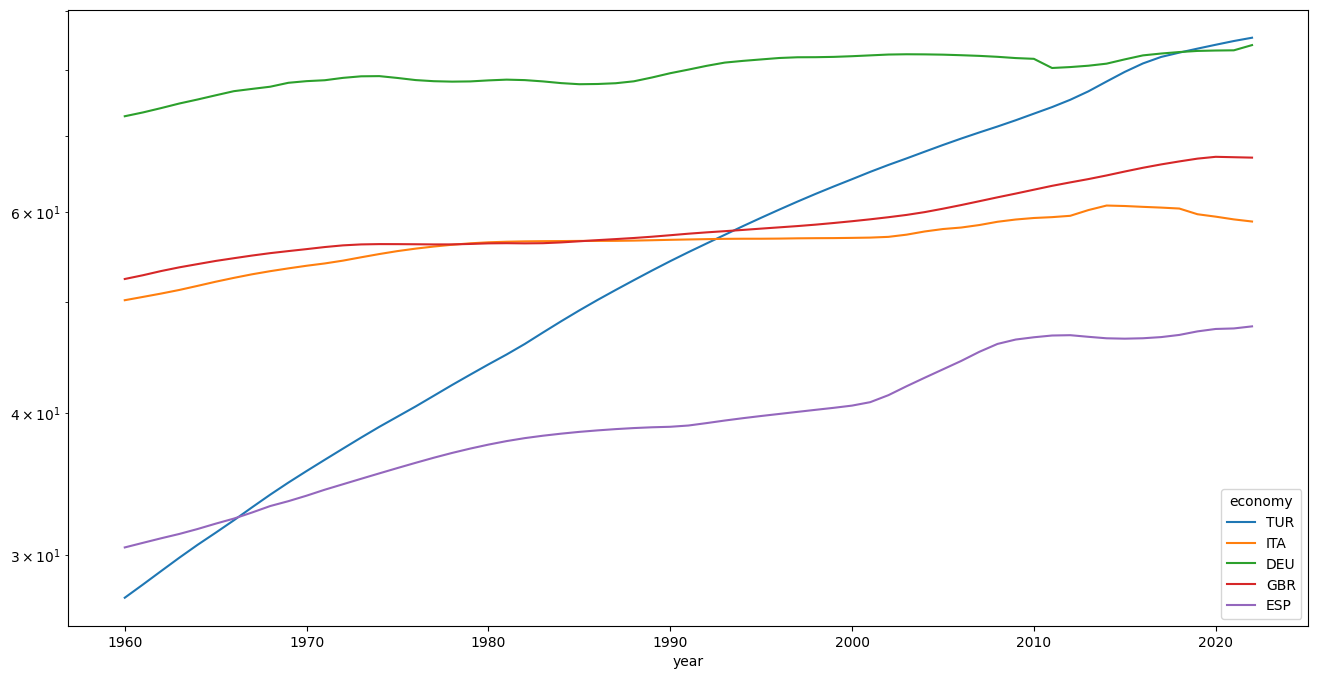

In [36]:
res[['TUR','ITA','DEU','GBR','ESP']].plot(figsize=(16,8),logy=True)

## Geological Survey Data

- [US Geological Survey (USGS)](https://www.usgs.gov/products) has a very large data store where you can get variety of scientific data that included Earthquakes, Satellite images, Maps, and much much more.
- [European Space Agency](https://open.esa.int/) has an excellent open data service from which you can access a variety of data products such as maps, satellite images and more.
- [NASA](https://data.nasa.gov/) also has an open data service.

####  An Example from NASA: Global Landslide Catalog Export

> The Global Landslide Catalog (GLC) was developed with the goal of identifying rainfall-triggered landslide events 
> around the world, regardless of size, impacts or location. The GLC considers all types of mass movements triggered 
> by rainfall, which have been reported in the media, disaster databases, scientific reports, or other sources. The 
> GLC has been compiled since 2007 at NASA Goddard Space Flight Center. This is a unique data set with the ID tag 
> “GLC” in the landslide editor.

In [37]:
landslides = pd.read_csv('https://data.nasa.gov/api/views/dd9e-wu2v/rows.csv?accessType=DOWNLOAD')

In [38]:
landslides.columns

Index(['source_name', 'source_link', 'event_id', 'event_date', 'event_time',
       'event_title', 'event_description', 'location_description',
       'location_accuracy', 'landslide_category', 'landslide_trigger',
       'landslide_size', 'landslide_setting', 'fatality_count', 'injury_count',
       'storm_name', 'photo_link', 'notes', 'event_import_source',
       'event_import_id', 'country_name', 'country_code',
       'admin_division_name', 'admin_division_population',
       'gazeteer_closest_point', 'gazeteer_distance', 'submitted_date',
       'created_date', 'last_edited_date', 'longitude', 'latitude'],
      dtype='object')

In [39]:
con = duckdb.connect('landslides')
con.query("""
    select count(event_date) as 'number of events', admin_division_name as city from landslides
        where country_name='Turkey'
        group by city;
""").to_df()

,number of events,city
0,1,Hakkâri
1,1,Siirt
2,1,Rize
3,5,Artvin
4,1,Sakarya
5,1,Zonguldak
6,1,Gümüşhane
7,2,Istanbul
8,2,Erzurum
9,1,Van


#### An Example from USGS

Paleohydrologic reconstructions of water-year streamflow for 31 stream gaging sites in the Missouri River Basin with complete data for 1685 through 1977

In [40]:
paleohydro = pd.read_csv('https://www.sciencebase.gov/catalog/file/get/5c994278e4b0b8a7f628903e?f=__disk__3d%2F8b%2F51%2F3d8b512c0dec73102f0c8d7b5c3e8d326dce54fa')    
paleohydro

,Latitude,Longitude,Gage or Reconstruction Name,USGS Gage ID,Year(row) /Id(col),1685,1686,1687,1688,1689,...,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977
0,45.116127,-112.75050,"Beaverhead River at Barretts, Montana",6016000,R1,444.433230,363.587220,794.49506,981.97470,658.24810,...,622.38715,600.00226,572.79840,728.22174,644.83290,591.26510,622.86070,612.43160,711.77300,425.95398
1,45.506912,-112.33089,"Ruby River near Twin Bridges, Montana",6023000,R2,219.264920,141.933170,245.13747,380.43802,185.72981,...,262.86417,316.82214,446.59970,305.67680,296.20413,241.70609,317.83478,381.02002,276.68330,232.38223
2,45.526581,-112.70172,"Big Hole River near Melrose, Montana",6025500,R3,1457.464000,1213.416700,1228.75370,932.24786,1080.46250,...,1378.20530,1602.58730,1269.83020,1799.21060,1339.16440,1042.20080,1608.72840,1624.03110,1836.77510,615.80316
3,45.897137,-111.59567,"Jefferson River near Three Forks, Montana",6036650,R4,2910.249800,2095.854500,3038.66970,3656.89580,2312.44870,...,3400.91630,3679.21660,3243.61080,3477.68460,2926.19140,2609.25900,3207.65870,3195.48750,3847.85770,2306.35380
4,45.490231,-111.63451,Madison River below Ennis Lake near McAllister...,6041000,R5,1215.694700,1445.360700,1898.49540,1967.13930,1418.36170,...,1961.48440,2027.46800,1646.18950,2304.48170,1867.69890,1773.10990,1891.25320,2068.86040,1942.11870,1431.26810
5,45.823559,-111.49966,"Madison River near Three Forks, Montana",6042500,R6,1529.759400,1630.721600,1848.33040,1986.04640,1639.65450,...,1835.35890,1960.75730,2249.08130,2346.00300,2089.77980,1816.17600,2281.50020,2089.39180,2072.58000,1471.04190
6,45.885357,-111.43829,"Gallatin River at Logan, Montana",6052500,R7,1158.373000,1124.973300,1156.45910,1501.32980,1279.30940,...,1519.12220,1522.14400,1686.82680,1896.32360,1329.28390,1280.63430,1437.24020,1702.78610,1755.73390,946.00340
7,46.146572,-111.42028,"Missouri River at Toston, Montana",6054500,R8,4906.707000,3933.409000,5750.33600,5431.72700,5060.82800,...,6346.73200,7067.96500,6532.60250,6476.41600,6229.90600,6263.93600,7455.65670,7631.82300,7175.91600,4608.80570
8,47.199024,-112.09591,"Dearborn River near Craig, Montana",6073500,R9,120.766320,188.489850,167.77414,112.52711,235.91763,...,169.14919,185.14203,207.92440,171.85780,140.97868,89.46792,172.00705,216.05415,281.65634,106.80695
9,47.190052,-111.38719,"Smith River near Eden, Montana",6077500,R10,296.586060,218.166660,249.01877,546.02515,730.56990,...,534.23740,535.42110,547.50714,377.71198,354.82062,353.42462,431.41824,615.23990,514.08124,272.23850


<Axes: >

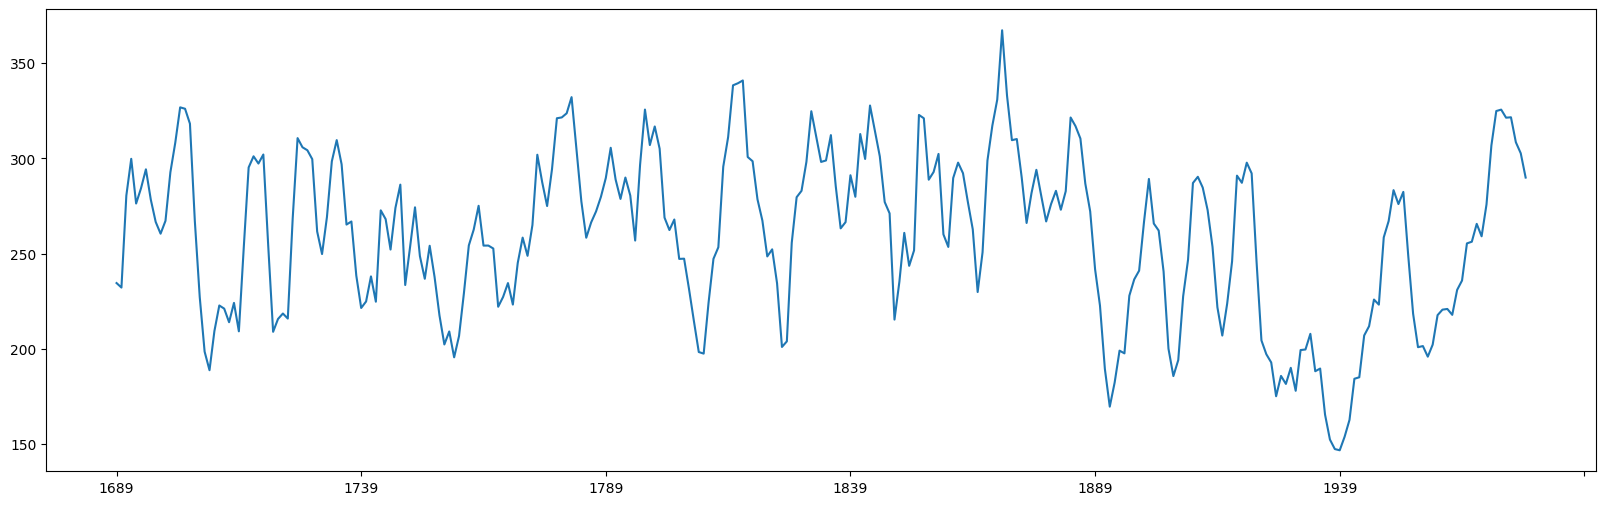

In [41]:
paleohydro.iloc[1,5:].rolling(window=5).mean().dropna().plot(figsize=(20,6))

#### Another example from USGS

In [42]:
def getEarthQuakeData(minlat,maxlat,minlong,maxlong,mag):
    params = {'starttime': '1995-01-01',
              'endtime': '2022-03-01',
              'minlatitude': minlat,
              'maxlatitude': maxlat,
              'minlongitude': minlong,
              'maxlongitude': maxlong,
              'minmagnitude': mag,
              'eventtype': 'earthquake',
              'producttype': 'origin'}
    url = f'https://earthquake.usgs.gov/fdsnws/event/1/query.csv?{urlencode(params)}' 
    return pd.read_csv(url)

In [43]:
tur = getEarthQuakeData(39,43,23,33, 3.5)
tur

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-02-20T20:20:11.665Z,40.7690,27.4040,10.00,4.4,mb,NaN,39.0,1.037,0.65,...,2022-05-04T13:39:02.040Z,"13 km SSW of Kumba?, Turkey",earthquake,2.3,2.0,0.189,8.0,reviewed,us,us
1,2022-02-06T12:07:52.856Z,40.5313,28.9725,11.00,4.2,mb,NaN,56.0,1.223,0.55,...,2022-04-19T17:38:47.040Z,"11 km SSW of Kocadere, Turkey",earthquake,2.2,6.4,0.186,8.0,reviewed,us,us
2,2022-01-22T19:31:42.837Z,39.5763,28.8232,2.68,4.6,mwr,NaN,26.0,0.744,0.69,...,2022-04-09T20:18:50.040Z,"17 km E of Dursunbey, Turkey",earthquake,2.7,4.2,0.060,27.0,reviewed,us,us
3,2022-01-22T02:32:56.485Z,39.5734,24.2602,10.00,4.5,mb,NaN,66.0,1.462,1.36,...,2022-04-09T20:18:47.040Z,"58 km NE of Patitírion, Greece",earthquake,5.2,2.0,0.271,5.0,reviewed,us,us
4,2022-01-16T22:32:01.622Z,40.1249,24.4732,10.00,4.4,mb,NaN,52.0,1.300,0.78,...,2022-04-01T17:40:13.040Z,"24 km SE of Karyes, Greece",earthquake,5.3,1.7,0.149,13.0,reviewed,us,us
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,1995-01-22T22:27:29.330Z,40.6110,23.4000,10.00,4.0,ml,NaN,NaN,NaN,1.10,...,2014-11-07T00:57:10.483Z,"3 km WSW of Néa Apollonía, Greece",earthquake,NaN,NaN,NaN,NaN,reviewed,us,the
1494,1995-01-18T12:36:34.170Z,40.0170,30.6410,10.00,3.6,md,NaN,NaN,NaN,0.60,...,2014-11-07T00:57:09.419Z,"5 km E of Mihalgazi, Turkey",earthquake,NaN,NaN,NaN,NaN,reviewed,us,isk
1495,1995-01-08T22:29:57.340Z,39.7960,30.5080,10.00,3.7,md,NaN,NaN,NaN,0.90,...,2014-11-07T00:57:06.907Z,"2 km NNW of Eski?ehir, Turkey",earthquake,NaN,NaN,NaN,NaN,reviewed,us,isk
1496,1995-01-08T13:08:54.980Z,39.3290,25.5500,27.00,4.2,mb,NaN,NaN,NaN,0.90,...,2014-11-07T00:57:06.860Z,"37 km WNW of Eresós, Greece",earthquake,NaN,2.3,NaN,18.0,reviewed,us,us


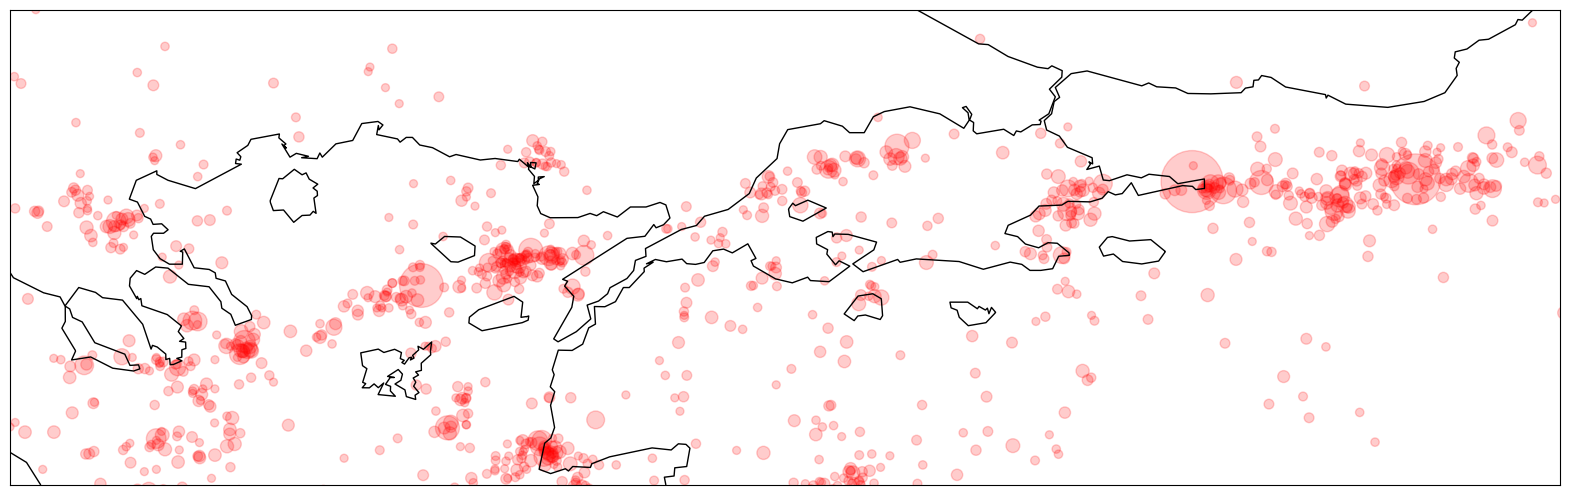

In [44]:
fig = plt.figure(figsize=(20,12))

m = Basemap(projection='merc',
           llcrnrlat = 39.4,
           urcrnrlat = 41.5,
           llcrnrlon = 23,
           urcrnrlon = 32,
           resolution='i')

m.drawcoastlines()

xs,ys = m(tur['longitude'], tur['latitude'])
sizes = np.exp(tur['mag'])

m.scatter(xs, ys, s=sizes, c='red', alpha=0.2)

plt.show()

# Satellite Image Data

1. [Hyperspectral Remote Sensing Scenes](http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes)
2. [A large list of open GIS Image data sets](https://freegisdata.rtwilson.com/)

In [45]:
pollution = pd.read_excel('https://www.eea.europa.eu/data-and-maps/data/air-pollutant-concentrations-at-station/air-pollutant-concentrations-2017/air-pollutant-concentrations-2017-compared-1/at_download/file',skiprows=0)
pollution

,PM10 measurements at station level in 2017,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,WHO air quality guideline for particulate matt...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AirPollutionLevel is the annual mean PM10 conc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2928,Germany,NaN,DEUB044,Zugspitze Schneefernerhaus,PM10,3.719975,ug/m3,Background,rural,10.980657,47.414435999999995,2650
2929,Finland,NaN,FI00356,Sammaltunturi,PM10,2.722191,ug/m3,Background,rural,24.112330000000004,67.96714999962705,566
2930,Sweden,NaN,SE0005R,Bredkälen,PM10,2.714006,ug/m3,Background,rural,15.31973,63.845496999575694,380
2931,Iceland,NaN,IS0039A,Reykjanes Leiran,PM10,2.633037,ug/m3,Industrial,suburban,-22.600490999999998,64.04275699957795,371


In [46]:
pollution.columns = pollution.iloc[5,:]
pollution.drop(range(6),inplace=True)
pollution

5,Country,City,AirQualityStationEoICode,AQStationName,AirPollutant,AirPollutionLevel,UnitOfAirpollutionLevel,AirQualityStationType,AirQualityStationArea,Longitude,Latitude,Altitude
6,Turkey,NaN,TR760141,IGDIR,PM10,114.235046,ug/m3,Background,urban,44.05361,39.9261099994713,859
7,Turkey,NaN,TR460241,KAHRAMANMARAS-ELBISTAN,PM10,99.351826,ug/m3,Background,urban,37.19834,38.203839999477836,1141
8,Turkey,NaN,TR160141,BURSA,PM10,94.415068,ug/m3,Background,urban,29.03806,40.23442999947032,92
9,Turkey,NaN,TR060641,ANKARA-KAYAS,PM10,92.578767,ug/m3,Background,urban,32.92676,39.925379999471296,922
10,Turkey,NaN,TR600241,TOKAT-ERBAA,PM10,85.759132,ug/m3,Background,urban,36.56163,40.67177999946905,246
...,...,...,...,...,...,...,...,...,...,...,...,...
2928,Germany,NaN,DEUB044,Zugspitze Schneefernerhaus,PM10,3.719975,ug/m3,Background,rural,10.980657,47.414435999999995,2650
2929,Finland,NaN,FI00356,Sammaltunturi,PM10,2.722191,ug/m3,Background,rural,24.112330000000004,67.96714999962705,566
2930,Sweden,NaN,SE0005R,Bredkälen,PM10,2.714006,ug/m3,Background,rural,15.31973,63.845496999575694,380
2931,Iceland,NaN,IS0039A,Reykjanes Leiran,PM10,2.633037,ug/m3,Industrial,suburban,-22.600490999999998,64.04275699957795,371


In [47]:
for x in ['AirPollutionLevel','Longitude','Latitude']:
    pollution[x] = pd.to_numeric(pollution[x])

In [48]:
con = duckdb.connect('pollution')
tmp = con.query("""
    select AirPollutionLevel, Longitude, Latitude from pollution
        where Country = 'Turkey';
""").to_df()
tmp

,AirPollutionLevel,Longitude,Latitude
0,114.235046,44.05361,39.92611
1,99.351826,37.19834,38.20384
2,94.415068,29.03806,40.23443
3,92.578767,32.92676,39.92538
4,85.759132,36.56163,40.67178
...,...,...,...
167,11.989384,28.14720,37.34312
168,10.760904,28.98277,41.08773
169,8.669331,34.99564,42.07376
170,7.594292,42.45997,37.51999


In [157]:
tmp = pollution[['AirPollutionLevel','Longitude','Latitude']][pollution['Country']=='Turkey']
tmp

5,AirPollutionLevel,Longitude,Latitude
6,114.235046,44.05361,39.92611
7,99.351826,37.19834,38.20384
8,94.415068,29.03806,40.23443
9,92.578767,32.92676,39.92538
10,85.759132,36.56163,40.67178
...,...,...,...
2703,11.989384,28.14720,37.34312
2791,10.760904,28.98277,41.08773
2871,8.669331,34.99564,42.07376
2895,7.594292,42.45997,37.51999


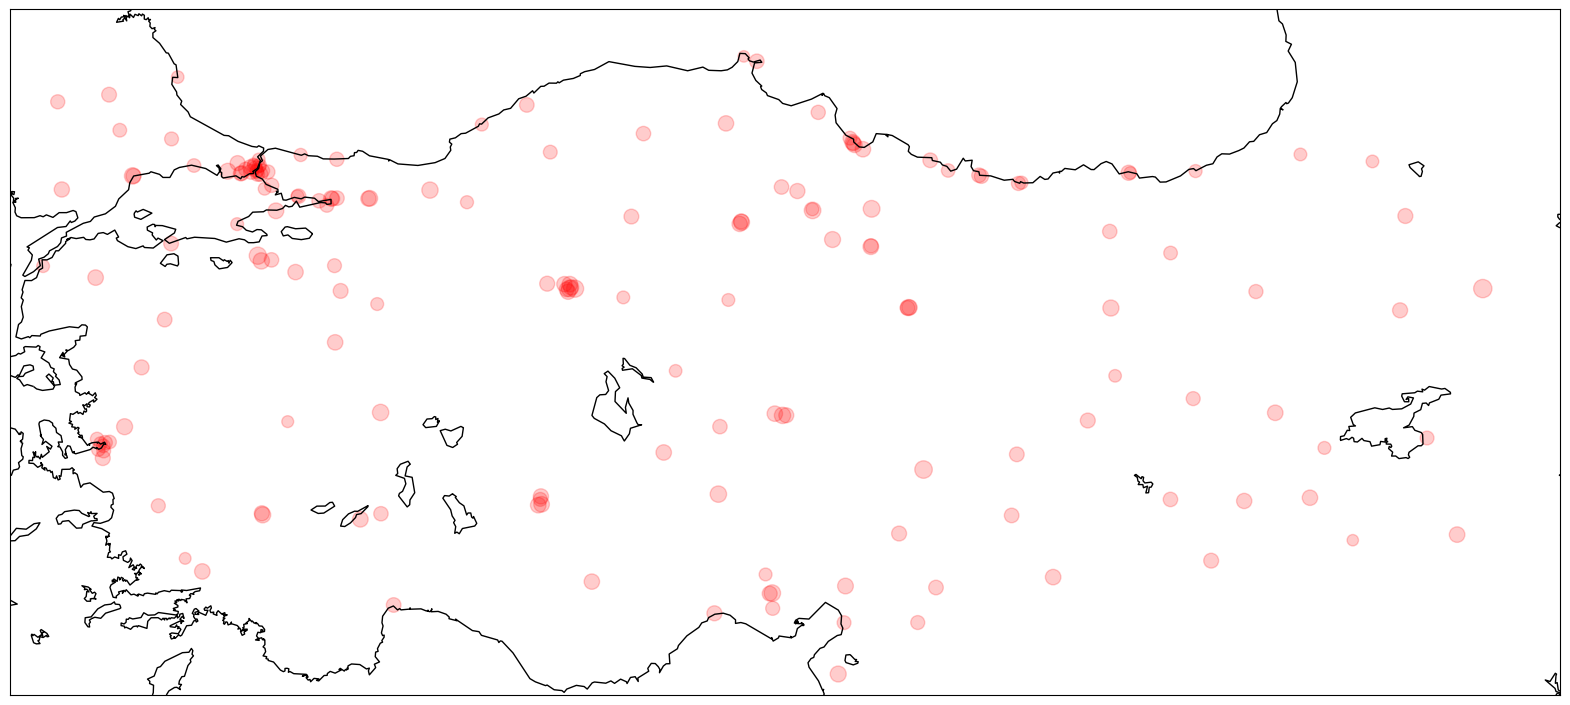

In [75]:
fig = plt.figure(figsize=(20,12))

m = Basemap(projection='merc',
           llcrnrlat = 36,
           llcrnrlon = 26,
           urcrnrlat = 42.5,
           urcrnrlon = 45,
           resolution='i')

m.drawcoastlines()

xs,ys = m(tmp['Longitude'], tmp['Latitude'])
sizes = tmp['AirPollutionLevel']+60

m.scatter(xs, ys, s=sizes, c='red', alpha=0.2)

plt.show()